# Loading Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning

In [ ]:
# Our data set is taken from Kaggle
# https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data
# We are going to be creating a model that can detect fake news only in the english language
data = pd.read_csv('/content/drive/MyDrive/fake-news/WELFake_Dataset.csv')

data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [ ]:
# Let us look at how our data looks like
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
# It seems like the Unnamed column is an id column, let us rename it
data.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)

data.head()

,id,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
# Let us look at the null values
data.isnull().sum()

id         0
title    558
text      39
label      0
dtype: int64

In [ ]:
# Here, we drop all the rows with null text and null title entries as these will affect our analysis
data.dropna(subset=['text','title'], inplace=True)
data.describe()
# We dropped a total of 72134-71537 = 597 rows with null values

,id,label
count,71537.000000,71537.000000
mean,36045.667599,0.510351
std,20826.109542,0.499896
min,0.000000,0.000000
25%,18000.000000,0.000000
50%,36035.000000,1.000000
75%,54083.000000,1.000000
max,72133.000000,1.000000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# As we can see, there are non-English words in the dataset, we only want english articles,
# Thus, let us check for non english words by using the following function to check
# strings for ascii-ness
def isEnglish(s):
  return s.isascii()

# Look for articles that are mostly in non ascii, tokenize word count of the text and
# remove if they are largely non-english
# This step is to clean the data, remove articles that are non-English

def remove_foreign(data):
  article_no = 0
  to_delete = []
  for item in data.text:
    vect = CountVectorizer(lowercase=True)
    item = [item]
    try:
      counts = vect.fit_transform(item)
      eng = 0
      non_eng = 0
      for word in vect.get_feature_names_out():
        # If more than 50% of the document contains non ascii, we consider it to be non-English
        if not isEnglish(word):
          non_eng += 1
        else:
          eng += 1
      if non_eng/(non_eng+eng) > 0.5:
        to_delete.append(data.iloc[article_no].id)
    except:
      to_delete.append(data.iloc[article_no].id)
    article_no+=1
  # Delete articles that are non-English
  for article in to_delete:
    data.drop(data[data['id'] == article].index, inplace = True)
    return data


In [ ]:
# Let us remove foreign language documents as we are only aiming to classify english documents
data = remove_foreign(data)

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# Next, we will be doing word processing on the data
# nltk provides us a corpus of stopwords to remove from our text to improve
# the results of CountVectorizer



# This function process the text into words separated by a space and removes
# stopwords, which are words such as 'a', 'of', 'at' with no meaning that
# are insignificant to our classification model
def process_text(data):
    preprocessed_text = []

    for sentence in data:
        # Match all words not letters, digits, or whitespace characters and remove
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  # Use nltk's stopword corpus
                                  if token not in stopwords.words('english')))
    return preprocessed_text



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Process Data
processed_text = process_text(data['text'].values)
data['text'] = processed_text

# There might be documents entirely composed of stopwords thus leaving us with null values,
# We have to remove them
data.isnull().sum()
data.dropna(subset=['text','count'], inplace=True)

In [ ]:
# Let us save the processed data as it takes almost an hour to process it
# We can resume the rest of the notebook from this point to skip the lengthy processing time
data.to_csv('/content/drive/MyDrive/fake-news/processed.csv')


Unnamed: 0    0
id            0
title         0
text          0
label         0
dtype: int64

# Resume Cleaned Data

In [ ]:
# Next, let us remove outliers, articles that contain extremely little text
# Such that they are not useful in telling us if an article is fake or not
# These articles are likely a result of parsing error
data = pd.read_csv('/content/drive/MyDrive/fake-news/processed.csv')

# Count number of words in each article text
data['count'] = data['text'].str.split().str.len()

In [ ]:
# Since our class distribution is not balanced, let us balance it, we sample 35027 random
# values of fake news and create a new dataframe with balanced classes
# This will ensure the model will not be biased
df1 = data[data['label'] == 0]
df2 = data[data['label'] == 1].sample(n = 35027)
df = pd.concat([df1, df2], axis=0)
df = df.sort_values('id')
df['label'].value_counts()

label
1    35027
0    35027
Name: count, dtype: int64

# Data Visualization


In [ ]:
# Let us plot the word counts of all these articles in a boxplot and look at some
# values
sns.boxplot(y='count', data=data)

In [ ]:
# Let us look at the values
data['count'].describe()

# Calculate IQR
Q1 = data['count'].quantile(0.25)
Q3 = data['count'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)


263.0


In [ ]:
# How many words must an article have to be useful? Let us look at the Q1 values
# Let us look at the distribution of word counts between fake and real
# We omit outliers to show the data better
# Min Q1-1.5*IQR Max Q3+1.5*IQR
fake_data = data[(data['label'] == 1) & ((data['count'] >= Q1-1.5*IQR) & (data['count'] <= Q3+1.5*IQR))]
real_data = data[(data['label'] == 0) & ((data['count'] >= Q1-1.5*IQR) & (data['count'] <= Q3+1.5*IQR))]

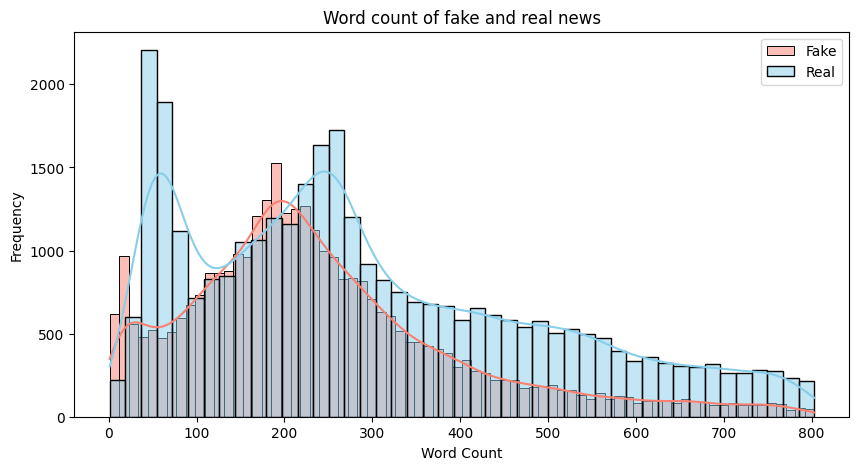

In [ ]:
# sns.histplot(data=new_data, x='count', bins=181, kde=True)

# Create side-by-side histograms using Seaborn
plt.figure(figsize=(10, 5))
sns.histplot(data=fake_data['count'], color='salmon', label='Fake', kde=True)
sns.histplot(data=real_data['count'], color='skyblue', label='Real', kde=True)

# Add titles and labels
plt.title('Word count of fake and real news')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Show the plot
plt.show()

# We can see that there are a large number of real news that have low word counts

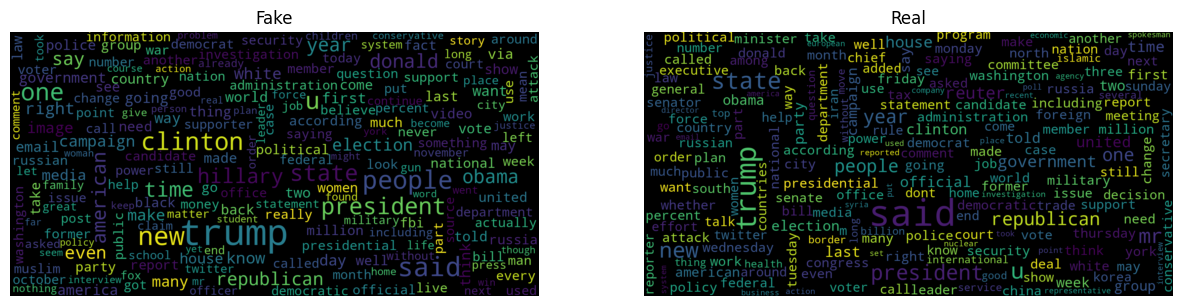

In [ ]:
# Word cloud
from wordcloud import WordCloud
fake_consolidated = ' '.join(
    word for word in fake_data['text'].astype(str))
real_consolidated = ' '.join(
    word for word in real_data['text'].astype(str))

# Collocations false to remove words that come together
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
# Create subplots
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordCloud.generate(fake_consolidated), interpolation='bilinear')
plt.title('Fake')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordCloud.generate(real_consolidated), interpolation='bilinear')
plt.title('Real')
plt.axis('off')

plt.show()


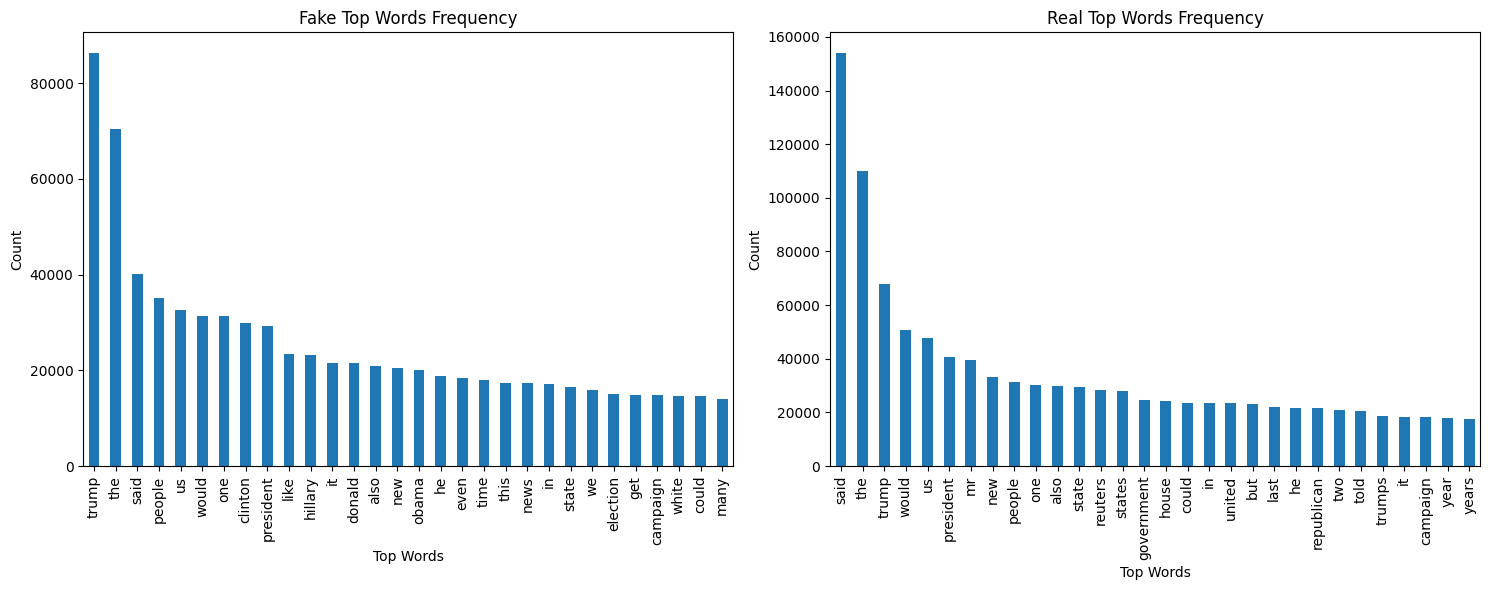

In [ ]:
# Top 30 most frequent words for fake and real
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(data, n=None):
    vec = CountVectorizer().fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


fake_common_words = get_top_n_words(fake_data['text'], 30)
real_common_words = get_top_n_words(real_data['text'], 30)
df_fake = pd.DataFrame(fake_common_words, columns=['Word', 'count'])
df_real = pd.DataFrame(real_common_words, columns=['Word', 'count'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

df_fake.groupby('Word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    ax=axs[0],
    xlabel="Top Words",
    ylabel="Count",
    title="Fake Top Words Frequency"
)
df_real.groupby('Word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    ax=axs[1],
    xlabel="Top Words",
    ylabel="Count",
    title="Real Top Words Frequency"
)
plt.tight_layout()
plt.show()

label
1    35766
0    35027
Name: count, dtype: int64

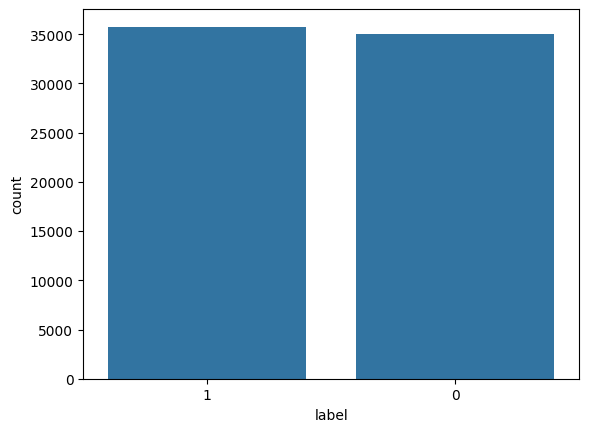

In [ ]:
# We can see that real news distribution of word count

# Next, let us use look at the class distribution of fake and non-fake articles
# Label pertains to 1 = fake, 0 = real
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)
data['label'].value_counts()

# Making Models (TFIDF)

In [ ]:
# Now that we have cleaned the values and balanced our data distribution, let us
# train our data with a variety of methods and classifiers to determine which
# gives us the best results
# We will use the following methods:
# 1) Word count
# 2) TFID / Term Frequency Inverse Document Frequency
# With the following classifiers:
# 1) Naive Bayes
# 2) Random Forest

# First, we split data into test and train in a 80-20 split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to Process Data Using TFIDF
def tfidf_process(df):
    # First, we split data into test and train in a 80-20 split
    x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                      df['label'],
                                                      test_size=0.20)

    # Running TfidfVectorizer to vectorize the words
    # We shall use the top 10000 most frequent words as features as anymore will be too much
    # Match a token pattern of only words
    tfidf_vectorization = TfidfVectorizer(analyzer= 'word', stop_words = 'english', max_features=10000, token_pattern=r'(?u)\b[A-Za-z]+\b')
    x_train_tfidf = tfidf_vectorization.fit_transform(x_train)
    x_test_tfidf = tfidf_vectorization.transform(x_test)
    tfidf_tokens = tfidf_vectorization.get_feature_names_out()

    # Standardize
    y_train_tfidf = y_train
    y_test_tfidf = y_test

    return x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens

x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df)

# Visualize
print(pd.DataFrame(data = x_train_tfidf.toarray(),columns = tfidf_tokens).head())


   aaron  abadi  abandon  abandoned  abandoning  abbas  abbott  abc  abcs  \
0    0.0    0.0      0.0        0.0         0.0    0.0     0.0  0.0   0.0   
1    0.0    0.0      0.0        0.0         0.0    0.0     0.0  0.0   0.0   
2    0.0    0.0      0.0        0.0         0.0    0.0     0.0  0.0   0.0   
3    0.0    0.0      0.0        0.0         0.0    0.0     0.0  0.0   0.0   
4    0.0    0.0      0.0        0.0         0.0    0.0     0.0  0.0   0.0   

   abdel  ...  zimbabwe  zimmerman  zinke  zionist  zone  zones  zoo   zu  \
0    0.0  ...       0.0        0.0    0.0      0.0   0.0    0.0  0.0  0.0   
1    0.0  ...       0.0        0.0    0.0      0.0   0.0    0.0  0.0  0.0   
2    0.0  ...       0.0        0.0    0.0      0.0   0.0    0.0  0.0  0.0   
3    0.0  ...       0.0        0.0    0.0      0.0   0.0    0.0  0.0  0.0   
4    0.0  ...       0.0        0.0    0.0      0.0   0.0    0.0  0.0  0.0   

   zuckerberg      zuma  
0         0.0  0.000000  
1         0.0  0.83313

# Making Models (Word Count)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to Process Data Using Word Count
def wc_process(df):
    # First, we split data into test and train in a 80-20 split
    x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                        df['label'],
                                                        test_size=0.20)

    # Running CountVectorizer to convert to word counts
    # We shall use the top 10000 most frequent words as features as anymore will be too much
    # Match a token pattern of only words
    wc_vectorization = CountVectorizer(analyzer= 'word', stop_words = 'english', max_features=10000, token_pattern=r'(?u)\b[A-Za-z]+\b')
    x_train_wc = wc_vectorization.fit_transform(x_train)
    x_test_wc = wc_vectorization.transform(x_test)
    wc_tokens = wc_vectorization.get_feature_names_out()

    # Standardize
    y_train_wc = y_train
    y_test_wc = y_test

    return x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens

x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df)

# Visualize
print(pd.DataFrame(data = x_train_wc.toarray(),columns = wc_tokens).head())

'''
x_train_wc
y_train
x_test_wc
y_test
'''

   aaron  abadi  abandon  abandoned  abandoning  abbas  abbott  abc  abcs  \
0      0      0        0          0           0      0       0    0     0   
1      0      0        0          0           0      0       0    0     0   
2      0      0        0          0           0      0       0    1     0   
3      0      0        0          0           0      0       0    0     0   
4      0      0        0          0           0      0       0    0     0   

   abdel  ...  zika  zimbabwe  zimmerman  zinke  zionist  zone  zones  zu  \
0      0  ...     0         0          0      0        0     0      0   0   
1      0  ...     0         0          0      0        0     0      0   0   
2      0  ...     0         0          0      0        0     0      0   0   
3      0  ...     0         0          0      0        0     0      0   0   
4      0  ...     0         0          0      0        0     0      0   0   

   zuckerberg  zuma  
0           0     0  
1           0     0  
2       

'\nx_train_wc\ny_train\nx_test_wc\ny_test\n'

# Classifying: Naive Bayes

In [ ]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

def mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc, alpha):
    # Create model MultinomialNB TFIDF Count
    tfidf_mnb = MultinomialNB().fit(x_train_tfidf, y_train_tfidf)

    # Create model MultinomialNB Word Count
    wc_mnb = MultinomialNB().fit(x_train_wc, y_train_wc)

    # Predict Values TFIDF
    y_test_pred_tfidf_mnb = tfidf_mnb.predict(x_test_tfidf)
    y_train_pred_tfidf_mnb = tfidf_mnb.predict(x_train_tfidf)

    # Predict Values Word Count
    y_test_pred_wc_mnb = wc_mnb.predict(x_test_wc)
    y_train_pred_wc_mnb = wc_mnb.predict(x_train_wc)

    return y_test_pred_tfidf_mnb, y_train_pred_tfidf_mnb, y_test_pred_wc_mnb, y_train_pred_wc_mnb

y_test_pred_tfidf_mnb, y_train_pred_tfidf_mnb, y_test_pred_wc_mnb, y_train_pred_wc_mnb = mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)

# Classifying: Random Forest

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 10m 35s run time

def rft(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc):
    # Create model Random Forest TFIDF
    tfidf_rft = RandomForestClassifier().fit(x_train_tfidf, y_train_tfidf)

    # Create model Random Forest Word Count
    wc_rft = RandomForestClassifier().fit(x_train_wc, y_train_wc)

    # Predict Values TFIDF
    y_test_pred_tfidf_rft = tfidf_rft.predict(x_test_tfidf)
    y_train_pred_tfidf_rft = tfidf_rft.predict(x_train_tfidf)

    # Predict Values Word Count
    y_test_pred_wc_rft = wc_rft.predict(x_test_wc)
    y_train_pred_wc_rft = wc_rft.predict(x_train_wc)

    return y_test_pred_tfidf_rft, y_train_pred_tfidf_rft, y_test_pred_wc_rft, y_train_pred_wc_rft
y_test_pred_tfidf_rft, y_train_pred_tfidf_rft, y_test_pred_wc_rft, y_train_pred_wc_rft = rft(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)

# Confusion Matrix and Accuracy

Naive Bayes using TFIDF Train Set Accuracy: 0.8558071480827222
Naive Bayes using TFIDF Test Set Accuracy: 0.8515452144743416
Naive Bayes using Word Count Train Set Accuracy: 0.8849811751690666
Naive Bayes using Word Count Test Set Accuracy: 0.8783098993647848
Random Forest using TFIDF Train Set Accuracy: 0.999982156558357
Random Forest using TFIDF Test Set Accuracy: 0.9568910142031262
Random Forest using Word Count Train Set Accuracy: 0.999982156558357
Random Forest using Word Count Test Set Accuracy: 0.9531082720719435




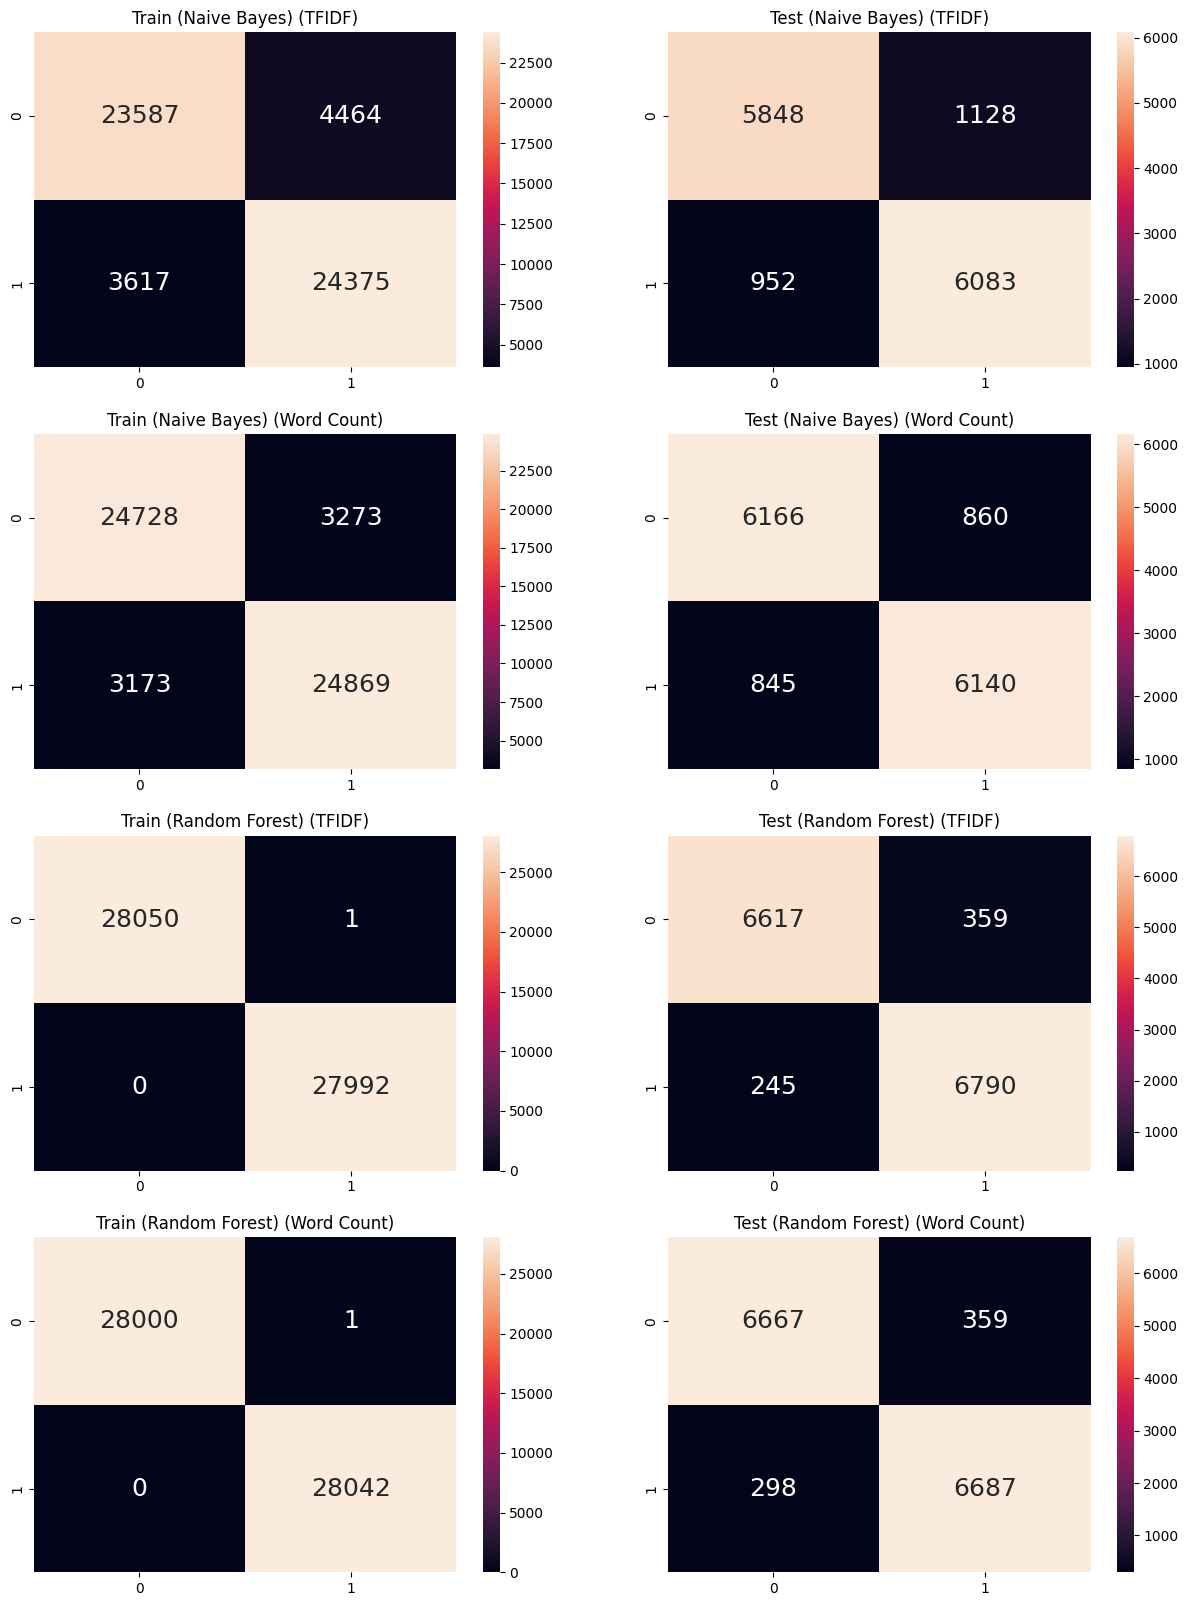

In [ ]:
from sklearn.metrics import confusion_matrix

def cf_and_acc (y_train_tfidf,
                y_test_tfidf,
                y_train_wc,
                y_test_wc,
                y_train_pred_tfidf_mnb,
                y_test_pred_tfidf_mnb,
                y_train_pred_wc_mnb,
                y_test_pred_wc_mnb,
                y_train_pred_tfidf_rft,
                y_test_pred_tfidf_rft,
                y_train_pred_wc_rft,
                y_test_pred_wc_rft) :
    # Accuracy Score for Train (Naive Bayes) (TFIDF)
    accuracy = accuracy_score(y_train_tfidf, y_train_pred_tfidf_mnb)
    print("Naive Bayes using TFIDF Train Set Accuracy: " + str(accuracy))
    # Accuracy Score for Test (Naive Bayes) (TFIDF)
    accuracy = accuracy_score(y_test_tfidf, y_test_pred_tfidf_mnb)
    print("Naive Bayes using TFIDF Test Set Accuracy: " + str(accuracy))

    # Accuracy Score for Train (Naive Bayes) (Word Count)
    accuracy = accuracy_score(y_train_wc, y_train_pred_wc_mnb)
    print("Naive Bayes using Word Count Train Set Accuracy: " + str(accuracy))
    # Accuracy Score for Test (Naive Bayes) (Word Count)
    accuracy = accuracy_score(y_test_wc, y_test_pred_wc_mnb)
    print("Naive Bayes using Word Count Test Set Accuracy: " + str(accuracy))

    # Accuracy Score for Train (Random Forest) (TFIDF)
    accuracy = accuracy_score(y_train_tfidf, y_train_pred_tfidf_rft)
    print("Random Forest using TFIDF Train Set Accuracy: " + str(accuracy))
    # Accuracy Score for Test (Random Forest) (TFIDF)
    accuracy = accuracy_score(y_test_tfidf, y_test_pred_tfidf_rft)
    print("Random Forest using TFIDF Test Set Accuracy: " + str(accuracy))

    # Accuracy Score for Train (Random Forest) (Word Count)
    accuracy = accuracy_score(y_train_wc, y_train_pred_wc_rft)
    print("Random Forest using Word Count Train Set Accuracy: " + str(accuracy))
    # Accuracy Score for Test (Random Forest) (Word Count)
    accuracy = accuracy_score(y_test_wc, y_test_pred_wc_rft)
    print("Random Forest using Word Count Test Set Accuracy: " + str(accuracy))
    print("\n")

    f, axes = plt.subplots(4, 2, figsize=(15, 20))

    # Confusion Matrix for Train (Naive Bayes) (TFIDF)
    sns.heatmap(
        confusion_matrix(y_train_tfidf, y_train_pred_tfidf_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[0][0],
    )
    axes[0][0].set_title("Train (Naive Bayes) (TFIDF)")
    # Confusion Matrix for Test (Naive Bayes) (TFIDF)
    sns.heatmap(
        confusion_matrix(y_test_tfidf, y_test_pred_tfidf_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[0][1],
    )
    axes[0][1].set_title("Test (Naive Bayes) (TFIDF)")


    # Confusion Matrix for Train (Naive Bayes) (Word Count)
    sns.heatmap(
        confusion_matrix(y_train_wc, y_train_pred_wc_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[1][0],
    )
    axes[1][0].set_title("Train (Naive Bayes) (Word Count)")
    # Confusion Matrix for Test (Naive Bayes) (Word Count)
    sns.heatmap(
        confusion_matrix(y_test_wc, y_test_pred_wc_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[1][1],
    )
    axes[1][1].set_title("Test (Naive Bayes) (Word Count)")


    # Confusion Matrix for Train (Random Forest) (TFIDF)
    sns.heatmap(
        confusion_matrix(y_train_tfidf, y_train_pred_tfidf_rft),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[2][0],
    )
    axes[2][0].set_title("Train (Random Forest) (TFIDF)")
    # Confusion Matrix for Test (Random Forest) (TFIDF)
    sns.heatmap(
        confusion_matrix(y_test_tfidf, y_test_pred_tfidf_rft),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[2][1],
    )
    axes[2][1].set_title("Test (Random Forest) (TFIDF)")


    # Confusion Matrix for Train (Random Forest) (Word Count)
    sns.heatmap(
        confusion_matrix(y_train_wc, y_train_pred_wc_rft),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[3][0],
    )
    axes[3][0].set_title("Train (Random Forest) (Word Count)")
    # Confusion Matrix for Test (Random Forest) (Word Count)
    sns.heatmap(
        confusion_matrix(y_test_wc, y_test_pred_wc_rft),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[3][1],
    )
    axes[3][1].set_title("Test (Random Forest) (Word Count)")
cf_and_acc (y_train_tfidf,
                y_test_tfidf,
                y_train_wc,
                y_test_wc,
                y_train_pred_tfidf_mnb,
                y_test_pred_tfidf_mnb,
                y_train_pred_wc_mnb,
                y_test_pred_wc_mnb,
                y_train_pred_tfidf_rft,
                y_test_pred_tfidf_rft,
                y_train_pred_wc_rft,
                y_test_pred_wc_rft)

# Optimizing: Lemmatization

[nltk_data] Downloading package wordnet to /root/nltk_data...


Naive Bayes using TFIDF Train Set Accuracy: 0.851970808129472
Naive Bayes using TFIDF Test Set Accuracy: 0.8448362001284705
Naive Bayes using Word Count Train Set Accuracy: 0.8776118337704977
Naive Bayes using Word Count Test Set Accuracy: 0.8727428449075726
Random Forest using TFIDF Train Set Accuracy: 0.999982156558357
Random Forest using TFIDF Test Set Accuracy: 0.9485404325173078
Random Forest using Word Count Train Set Accuracy: 0.999982156558357
Random Forest using Word Count Test Set Accuracy: 0.9458282777817429




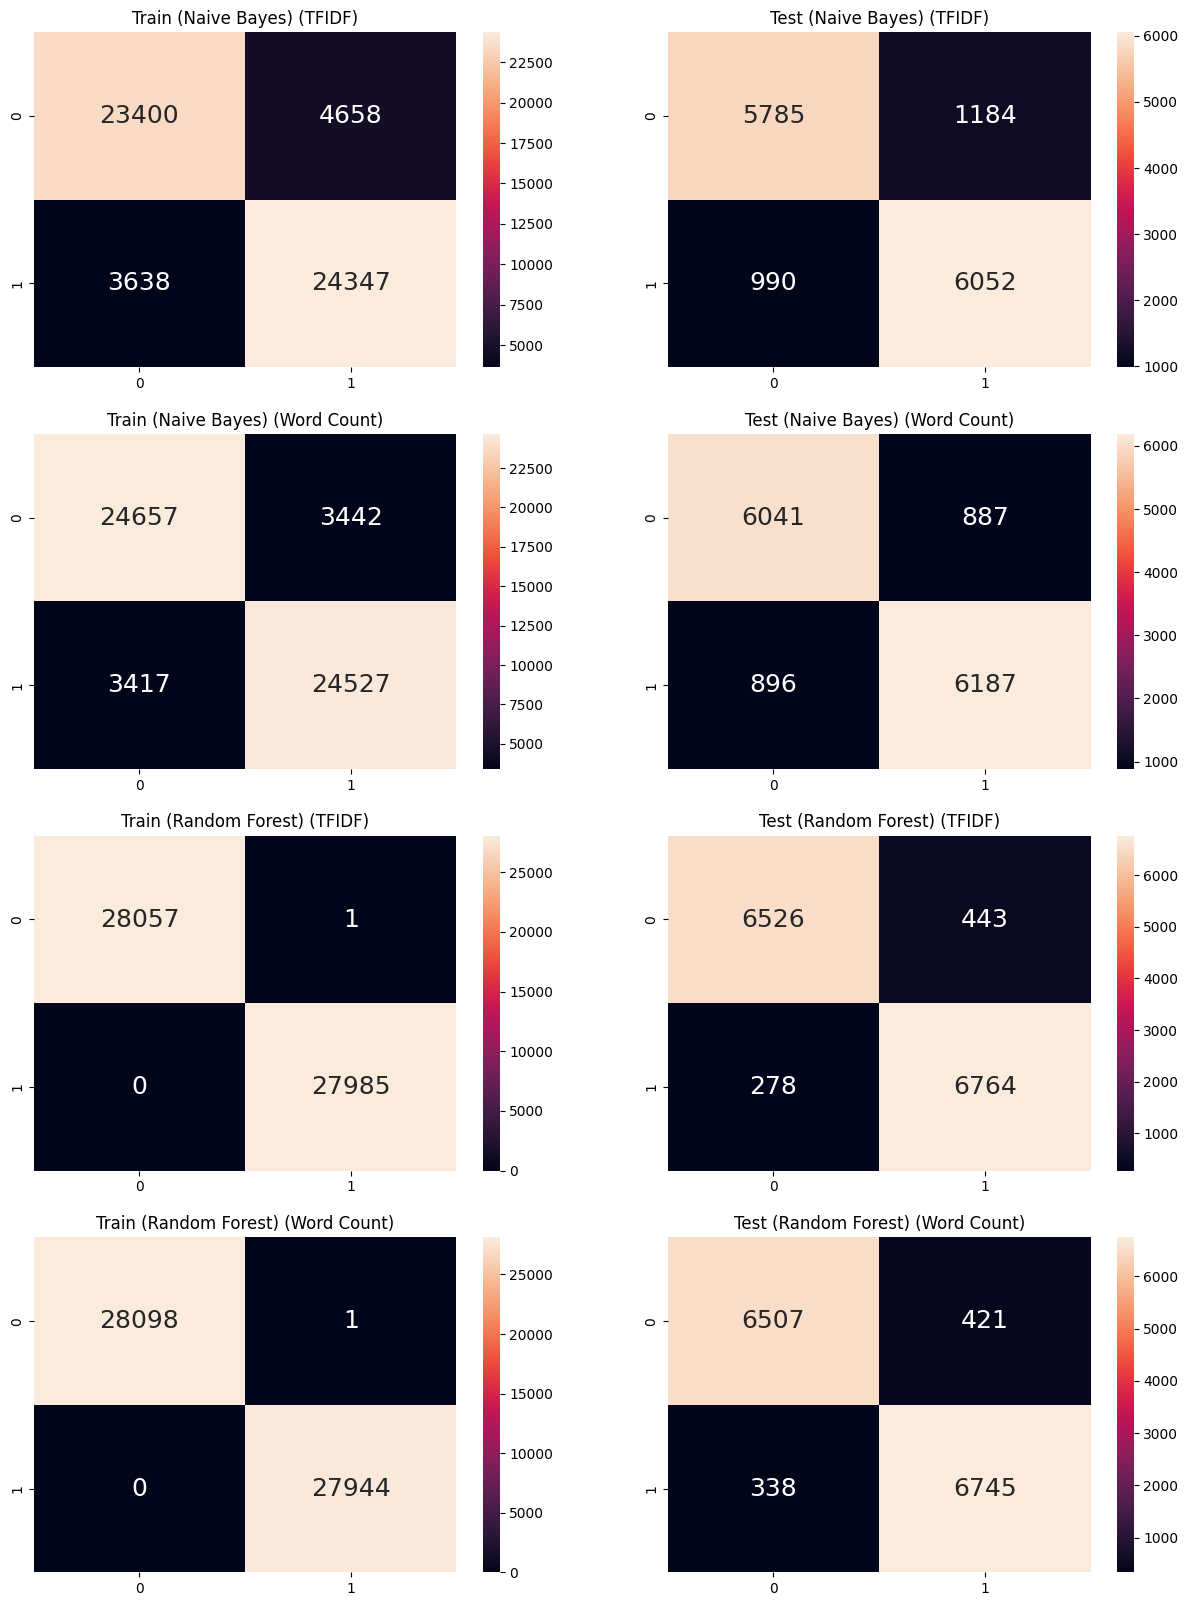

In [ ]:
# https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# Lemmatization is the process of obtaining the root word from words
# We will Lemmatize the data to see if it provides any boost to accuracy

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# Function to Lemmatize Words
def lemmatize_text(data):
    lemmatizer = WordNetLemmatizer()
    postlemmatized_text = []

    for sentence in data:
        sentence = sentence.split(" ")
        new = []
        for word in sentence:
            # Lemmatize all words
            new.append(lemmatizer.lemmatize(word))

        postlemmatized_text.append(' '.join(new))
    return postlemmatized_text

# Lemmatize Data
lemmatized_text = lemmatize_text(df['text'].values)

df_lem = df
df_lem['text'] = lemmatized_text

# Run TFIDF and Word Counts on it
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df_lem)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df_lem)
y_test_pred_tfidf_mnb, y_train_pred_tfidf_mnb, y_test_pred_wc_mnb, y_train_pred_wc_mnb = mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
y_test_pred_tfidf_rft, y_train_pred_tfidf_rft, y_test_pred_wc_rft, y_train_pred_wc_rft = rft(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
cf_and_acc (y_train_tfidf,
                y_test_tfidf,
                y_train_wc,
                y_test_wc,
                y_train_pred_tfidf_mnb,
                y_test_pred_tfidf_mnb,
                y_train_pred_wc_mnb,
                y_test_pred_wc_mnb,
                y_train_pred_tfidf_rft,
                y_test_pred_tfidf_rft,
                y_train_pred_wc_rft,
                y_test_pred_wc_rft)

# Optimizing: Named Entity Recognition

In [ ]:
# https://spacy.io/universe/project/video-spacys-ner-model-alt
# Allows for removing of words that are an obvious flag for real news such as the news organisation's name, reuters
# Or BuzzFeed
import spacy

# Function to remove NE from data
def ner_text(data):
    nlp = spacy.load("en_core_web_sm")
    postner_text = []

    for sentence in data:
        doc = nlp(sentence)
        for ent in doc.ents:
            sentence = sentence.replace(' ' + ent.text + ' ', ' ')
        postner_text.append(sentence)
    return postner_text




In [ ]:
# 1h 13 min run
# NER Data
nered_text = ner_text(df['text'].values)

df_ner = df
df_ner['text'] = nered_text
data.to_csv('/content/drive/MyDrive/fake-news/ner_processed.csv')

Naive Bayes using TFIDF Train Set Accuracy: 0.8596249602712152
Naive Bayes using TFIDF Test Set Accuracy: 0.8540151140617275
Naive Bayes using Word Count Train Set Accuracy: 0.8845746371437653
Naive Bayes using Word Count Test Set Accuracy: 0.8809237940532524
Random Forest using TFIDF Train Set Accuracy: 0.9999823427622982
Random Forest using TFIDF Test Set Accuracy: 0.9518327565506038
Random Forest using Word Count Train Set Accuracy: 0.9999823427622982
Random Forest using Word Count Test Set Accuracy: 0.9553640793841373




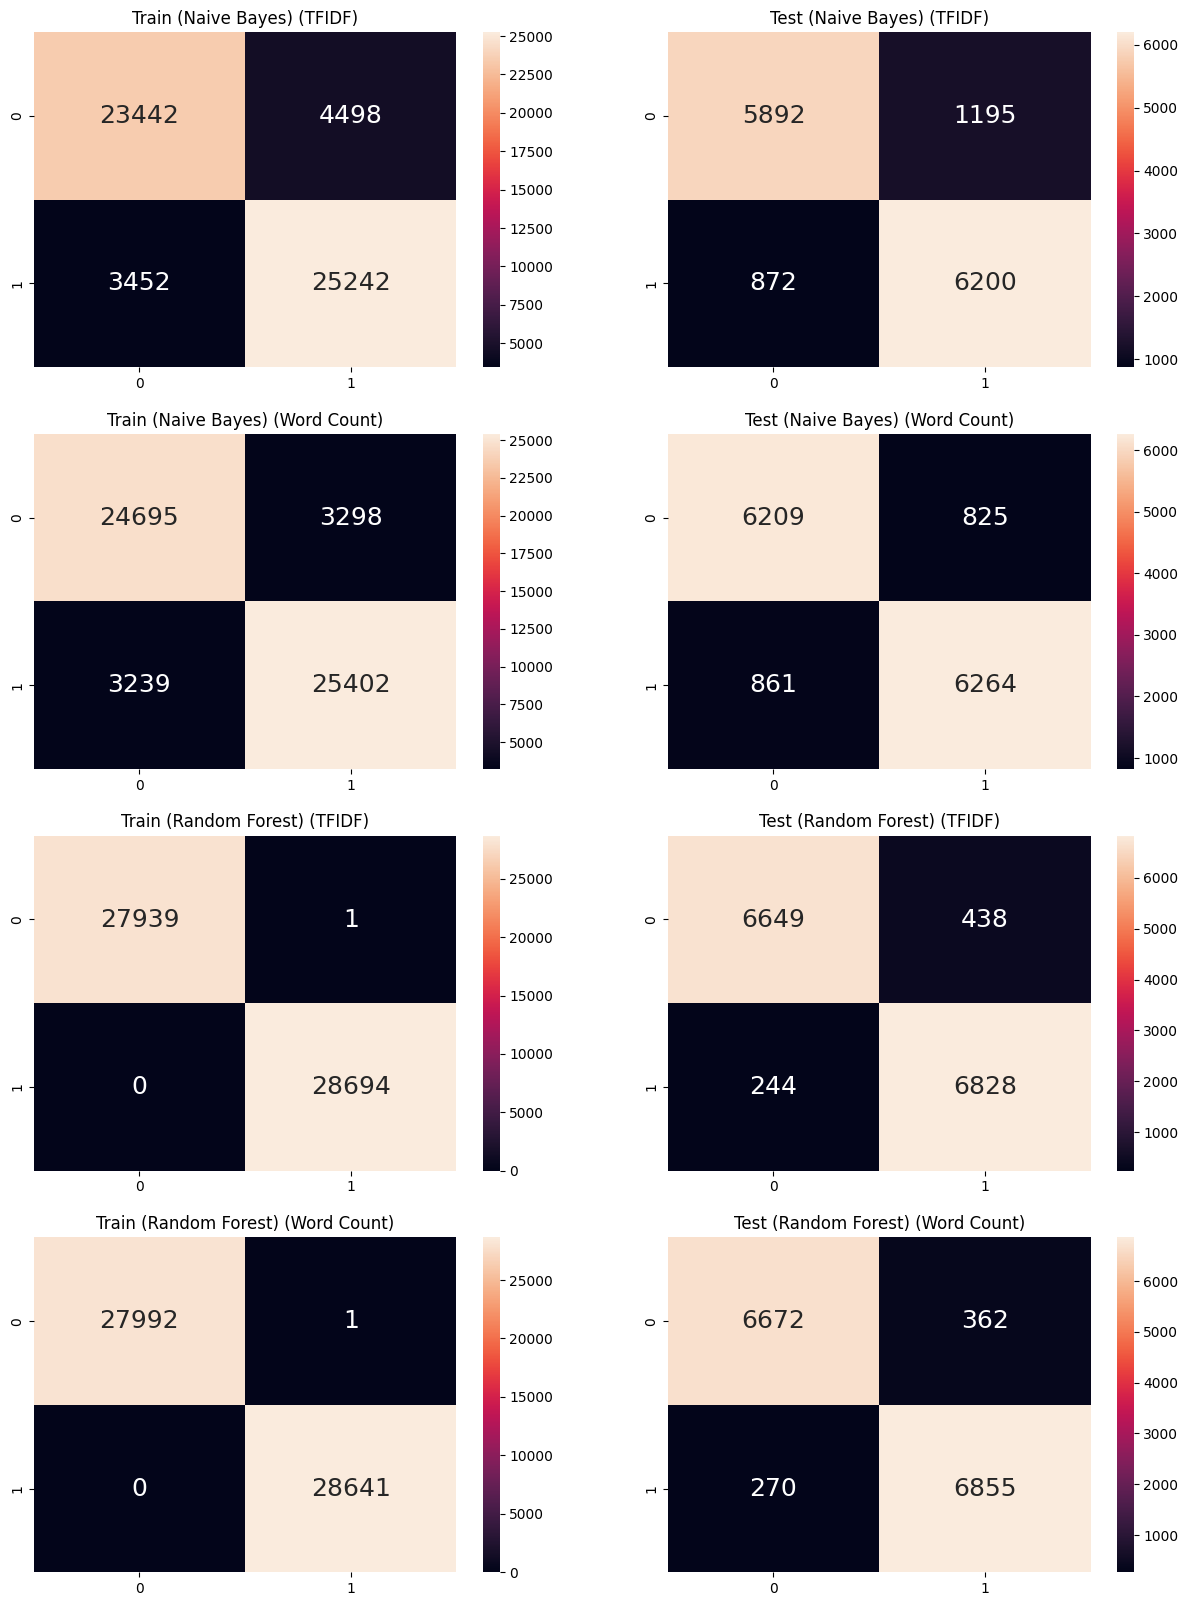

In [ ]:
# Resume from here as above runtime takes 1h 13 min
df_ner = pd.read_csv('/content/drive/MyDrive/fake-news/ner_processed.csv')

# Run TFIDF and Word Counts on it
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df_ner)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df_ner)
y_test_pred_tfidf_mnb, y_train_pred_tfidf_mnb, y_test_pred_wc_mnb, y_train_pred_wc_mnb = mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
y_test_pred_tfidf_rft, y_train_pred_tfidf_rft, y_test_pred_wc_rft, y_train_pred_wc_rft = rft(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
cf_and_acc (y_train_tfidf,
                y_test_tfidf,
                y_train_wc,
                y_test_wc,
                y_train_pred_tfidf_mnb,
                y_test_pred_tfidf_mnb,
                y_train_pred_wc_mnb,
                y_test_pred_wc_mnb,
                y_train_pred_tfidf_rft,
                y_test_pred_tfidf_rft,
                y_train_pred_wc_rft,
                y_test_pred_wc_rft)


# Optimizing: Lemmatization + NER

Naive Bayes using TFIDF Train Set Accuracy: 0.8546103047639227
Naive Bayes using TFIDF Test Set Accuracy: 0.847517480048026
Naive Bayes using Word Count Train Set Accuracy: 0.8798248402019988
Naive Bayes using Word Count Test Set Accuracy: 0.8742849071262094
Random Forest using TFIDF Train Set Accuracy: 0.9999823427622982
Random Forest using TFIDF Test Set Accuracy: 0.9464651458436331
Random Forest using Word Count Train Set Accuracy: 0.9999823427622982
Random Forest using Word Count Test Set Accuracy: 0.947312663323681




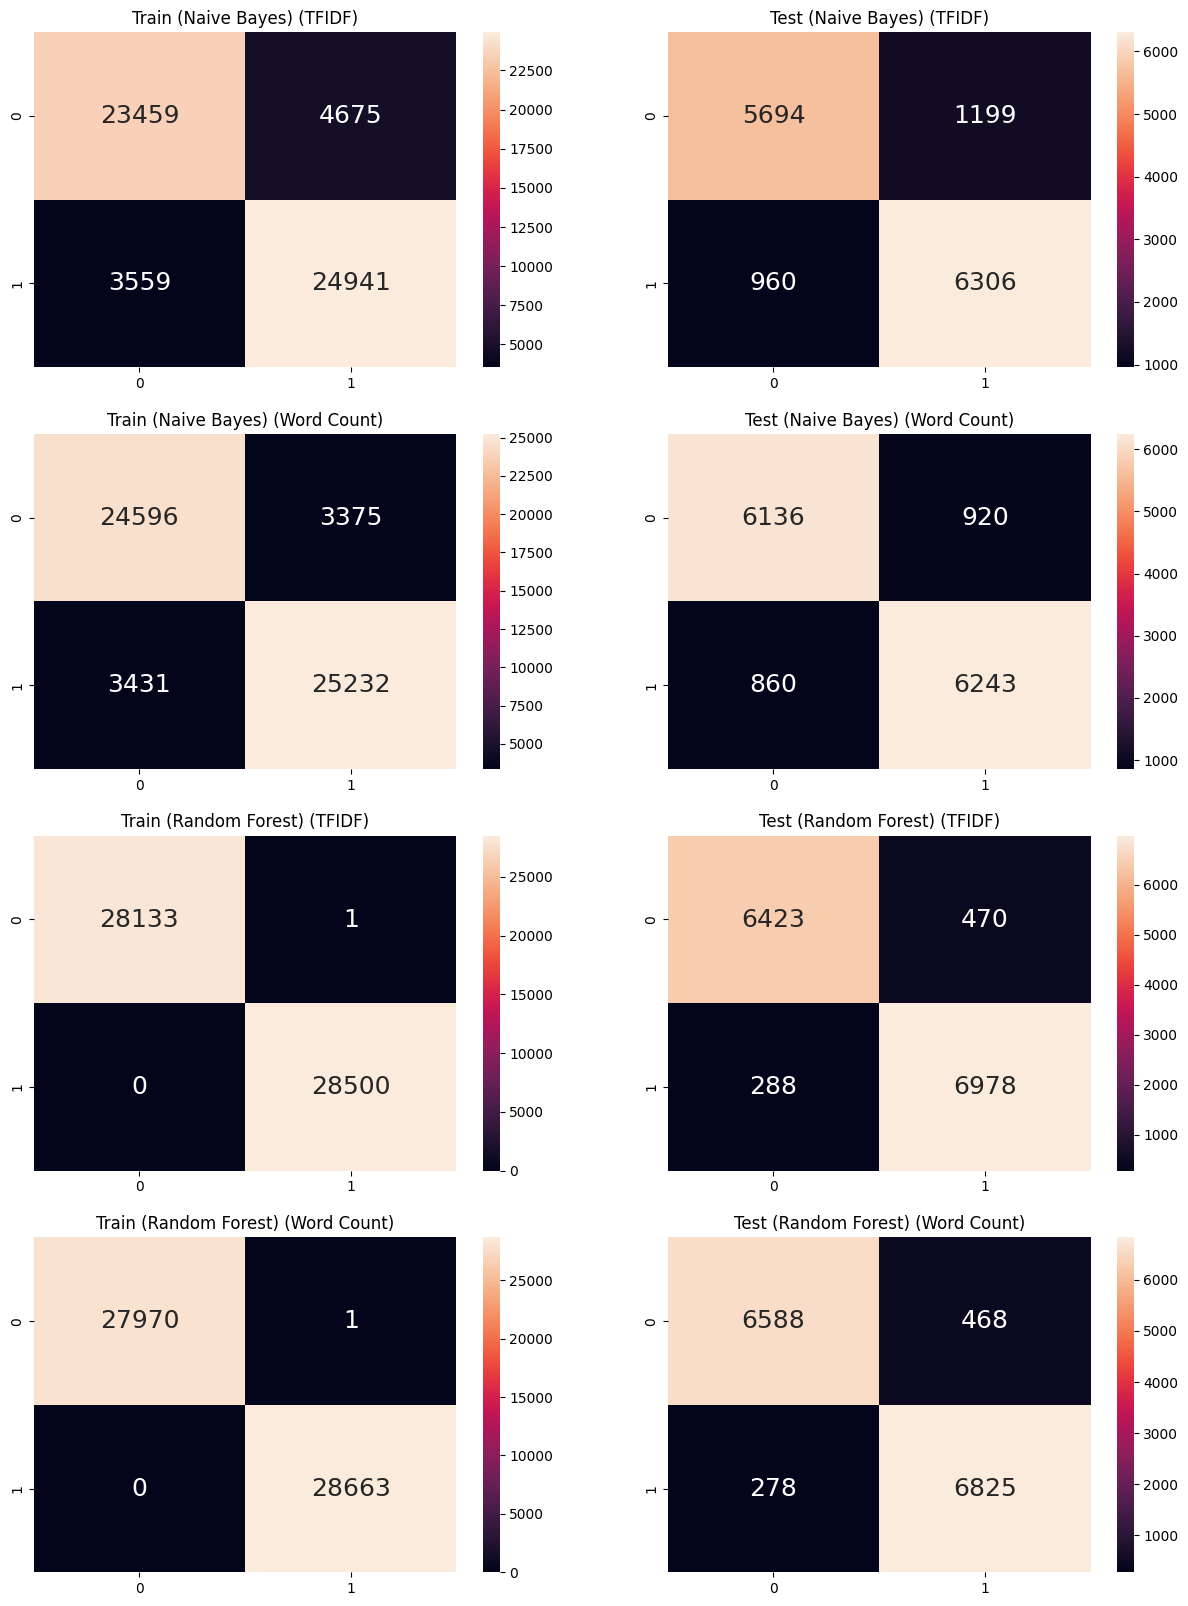

In [ ]:
# Lemmatize Data
lemmatized_text = lemmatize_text(df_ner['text'].values)

df_lem_ner = df_ner
df_lem_ner['text'] = lemmatized_text

# Run TFIDF and Word Counts on it
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df_lem_ner)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df_lem_ner)
y_test_pred_tfidf_mnb, y_train_pred_tfidf_mnb, y_test_pred_wc_mnb, y_train_pred_wc_mnb = mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
y_test_pred_tfidf_rft, y_train_pred_tfidf_rft, y_test_pred_wc_rft, y_train_pred_wc_rft = rft(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
cf_and_acc (y_train_tfidf,
                y_test_tfidf,
                y_train_wc,
                y_test_wc,
                y_train_pred_tfidf_mnb,
                y_test_pred_tfidf_mnb,
                y_train_pred_wc_mnb,
                y_test_pred_wc_mnb,
                y_train_pred_tfidf_rft,
                y_test_pred_tfidf_rft,
                y_train_pred_wc_rft,
                y_test_pred_wc_rft)


# Grid Search for Hyperparameters using Cross Validation


In [ ]:
# https://www.geeksforgeeks.org/hyperparameter-tuning/
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Function to Optimize Hyper Parameter for Naive Bayes
def optimize_hyper_nb(param, df):

    model = MultinomialNB()
    clf = GridSearchCV(model,param,scoring='accuracy',cv=10,return_train_score=True)

    x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df)
    x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df)

    # Create models
    tfidf_mnb = clf.fit(x_train_tfidf, y_train_tfidf)
    wc_mnb = clf.fit(x_train_wc, y_train_wc)

    # Print the tuned parameters and score
    print("Tuned Naive Bayes with TFIDF, Parameters: {}".format(tfidf_mnb.best_params_))
    print("Best score is {}".format(tfidf_mnb.best_score_))

    print("Tuned Naive Bayes with Word Count, Parameters: {}".format(wc_mnb.best_params_))
    print("Best score is {}".format(wc_mnb.best_score_))

# Grid Search NB Alpha Parameter
param = {'alpha': [0.000000001,0.00000001,0.0000001,0.000001,0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
print("Results with no Data Optimization")
optimize_hyper_nb(param, df)

print("\nResults with Lemmatization Optimization")
optimize_hyper_nb(param, df_lem)

print("\nResults with NER Optimization")
optimize_hyper_nb(param, df_ner)

print("\nResults with both Lemmatization and NER Optimization")
optimize_hyper_nb(param, df_lem_ner)

# Random Forest Not Used as Runtime is too impossibly long

Results with no Data Optimization
Tuned Naive Bayes with TFIDF, Parameters: {'alpha': 1e-09}
Best score is 0.8782007594931873
Tuned Naive Bayes with Word Count, Parameters: {'alpha': 1e-09}
Best score is 0.8782007594931873

Results with Lemmatization Optimization
Tuned Naive Bayes with TFIDF, Parameters: {'alpha': 1e-09}
Best score is 0.876630379345453
Tuned Naive Bayes with Word Count, Parameters: {'alpha': 1e-09}
Best score is 0.876630379345453

Results with NER Optimization
Tuned Naive Bayes with TFIDF, Parameters: {'alpha': 1e-09}
Best score is 0.880142796784759
Tuned Naive Bayes with Word Count, Parameters: {'alpha': 1e-09}
Best score is 0.880142796784759

Results with both Lemmatization and NER Optimization
Tuned Naive Bayes with TFIDF, Parameters: {'alpha': 1e-09}
Best score is 0.8795953432230824
Tuned Naive Bayes with Word Count, Parameters: {'alpha': 1e-09}
Best score is 0.8795953432230824


# Results of Using Optimized Hyperparameter

In [ ]:
# Function for Confusion Matrix and Accuracy for Naive Bayes Only
def cf_and_acc_mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc):

    # Create model MultinomialNB TFIDF Count
    tfidf_mnb = MultinomialNB(alpha=0.000000001).fit(x_train_tfidf, y_train_tfidf)

    # Create model MultinomialNB Word Count
    # Where alpha is 1e-09
    wc_mnb = MultinomialNB(alpha=0.000000001).fit(x_train_wc, y_train_wc)

    # Predict Values TFIDF
    y_test_pred_tfidf_mnb = tfidf_mnb.predict(x_test_tfidf)
    y_train_pred_tfidf_mnb = tfidf_mnb.predict(x_train_tfidf)

    # Predict Values Word Count
    y_test_pred_wc_mnb = wc_mnb.predict(x_test_wc)
    y_train_pred_wc_mnb = wc_mnb.predict(x_train_wc)

    # Accuracy Score for Train (Naive Bayes) (TFIDF)
    accuracy = accuracy_score(y_train_tfidf, y_train_pred_tfidf_mnb)
    print("Naive Bayes using TFIDF Train Set Accuracy: " + str(accuracy))
    # Accuracy Score for Test (Naive Bayes) (TFIDF)
    accuracy = accuracy_score(y_test_tfidf, y_test_pred_tfidf_mnb)
    print("Naive Bayes using TFIDF Test Set Accuracy: " + str(accuracy))

    # Accuracy Score for Train (Naive Bayes) (Word Count)
    accuracy = accuracy_score(y_train_wc, y_train_pred_wc_mnb)
    print("Naive Bayes using Word Count Train Set Accuracy: " + str(accuracy))
    # Accuracy Score for Test (Naive Bayes) (Word Count)
    accuracy = accuracy_score(y_test_wc, y_test_pred_wc_mnb)
    print("Naive Bayes using Word Count Test Set Accuracy: " + str(accuracy))

    f, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Confusion Matrix for Train (Naive Bayes) (TFIDF)
    sns.heatmap(
        confusion_matrix(y_train_tfidf, y_train_pred_tfidf_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[0][0],
    )
    axes[0][0].set_title("Train (Naive Bayes) (TFIDF)")
    # Confusion Matrix for Test (Naive Bayes) (TFIDF)
    sns.heatmap(
        confusion_matrix(y_test_tfidf, y_test_pred_tfidf_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[0][1],
    )
    axes[0][1].set_title("Test (Naive Bayes) (TFIDF)")


    # Confusion Matrix for Train (Naive Bayes) (Word Count)
    sns.heatmap(
        confusion_matrix(y_train_wc, y_train_pred_wc_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[1][0],
    )
    axes[1][0].set_title("Train (Naive Bayes) (Word Count)")
    # Confusion Matrix for Test (Naive Bayes) (Word Count)
    sns.heatmap(
        confusion_matrix(y_test_wc, y_test_pred_wc_mnb),
        annot=True,
        fmt=".0f",
        annot_kws={"size": 18},
        ax=axes[1][1],
    )
    axes[1][1].set_title("Test (Naive Bayes) (Word Count)")

Normal Data Set

Naive Bayes using TFIDF Train Set Accuracy: 0.8609282158342701
Naive Bayes using TFIDF Test Set Accuracy: 0.8506173720648063
Naive Bayes using Word Count Train Set Accuracy: 0.8817515122316792
Naive Bayes using Word Count Test Set Accuracy: 0.874884019698808


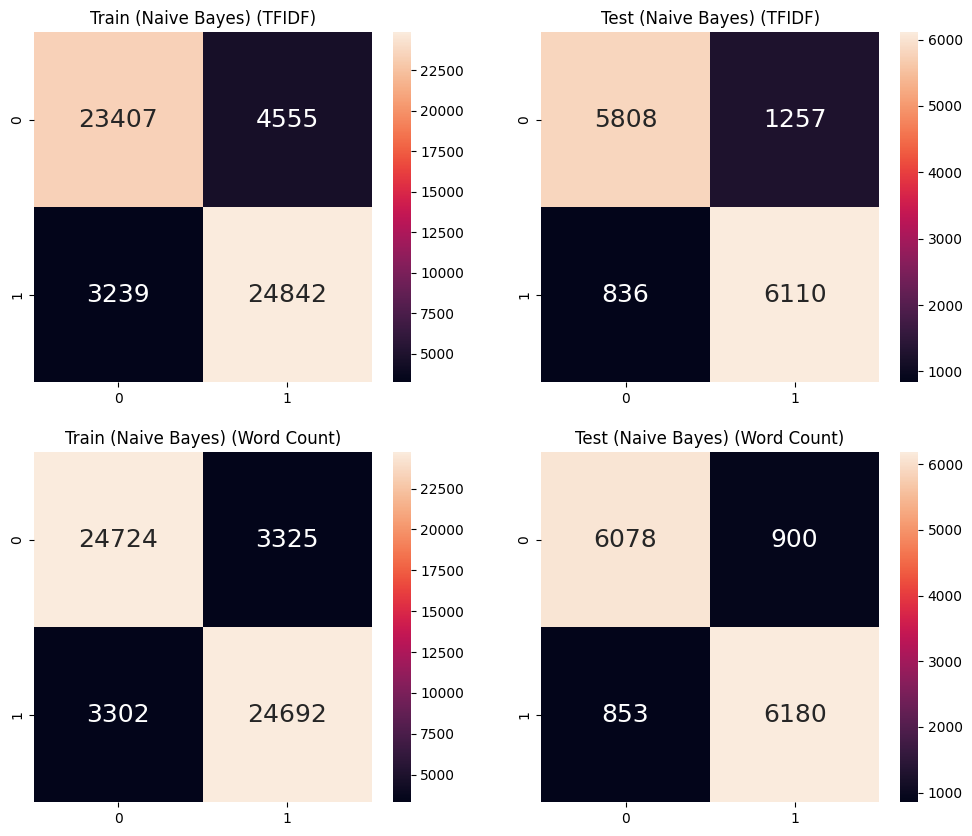

In [ ]:
# For Normal Dataset
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df)
cf_and_acc_mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)

Lemmatization

Naive Bayes using TFIDF Train Set Accuracy: 0.8611780240172725
Naive Bayes using TFIDF Test Set Accuracy: 0.8553279566055242
Naive Bayes using Word Count Train Set Accuracy: 0.8836964473707689
Naive Bayes using Word Count Test Set Accuracy: 0.8824495039611734


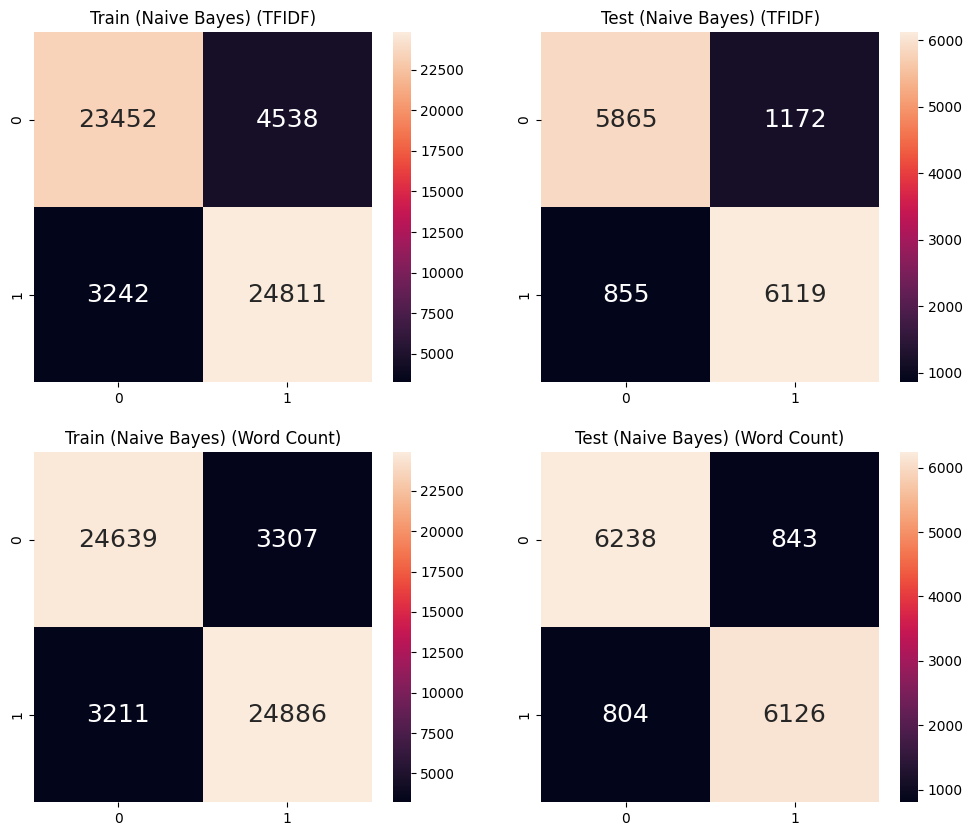

In [ ]:
# For LEM
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df_lem)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df_lem)
cf_and_acc_mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)

Named Entities Removed

Naive Bayes using TFIDF Train Set Accuracy: 0.8590952431401632
Naive Bayes using TFIDF Test Set Accuracy: 0.8584645808319796
Naive Bayes using Word Count Train Set Accuracy: 0.8828089133735918
Naive Bayes using Word Count Test Set Accuracy: 0.879723144289851


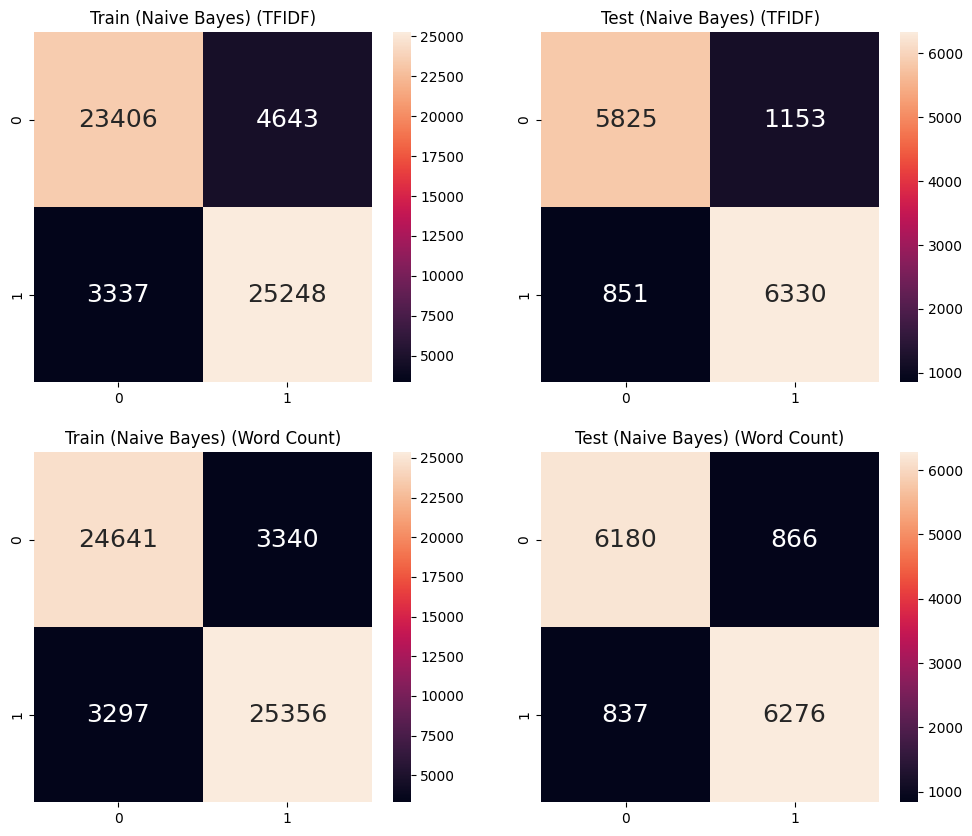

In [ ]:
# For NER
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df_ner)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df_ner)
y_test_pred_tfidf_mnb, y_train_pred_tfidf_mnb, y_test_pred_wc_mnb, y_train_pred_wc_mnb = mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)
cf_and_acc_mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)

Lemmatization + Named Entities Removed

Naive Bayes using TFIDF Train Set Accuracy: 0.860631422820214
Naive Bayes using TFIDF Test Set Accuracy: 0.8541563669750689
Naive Bayes using Word Count Train Set Accuracy: 0.8834445739308543
Naive Bayes using Word Count Test Set Accuracy: 0.8732961367328201


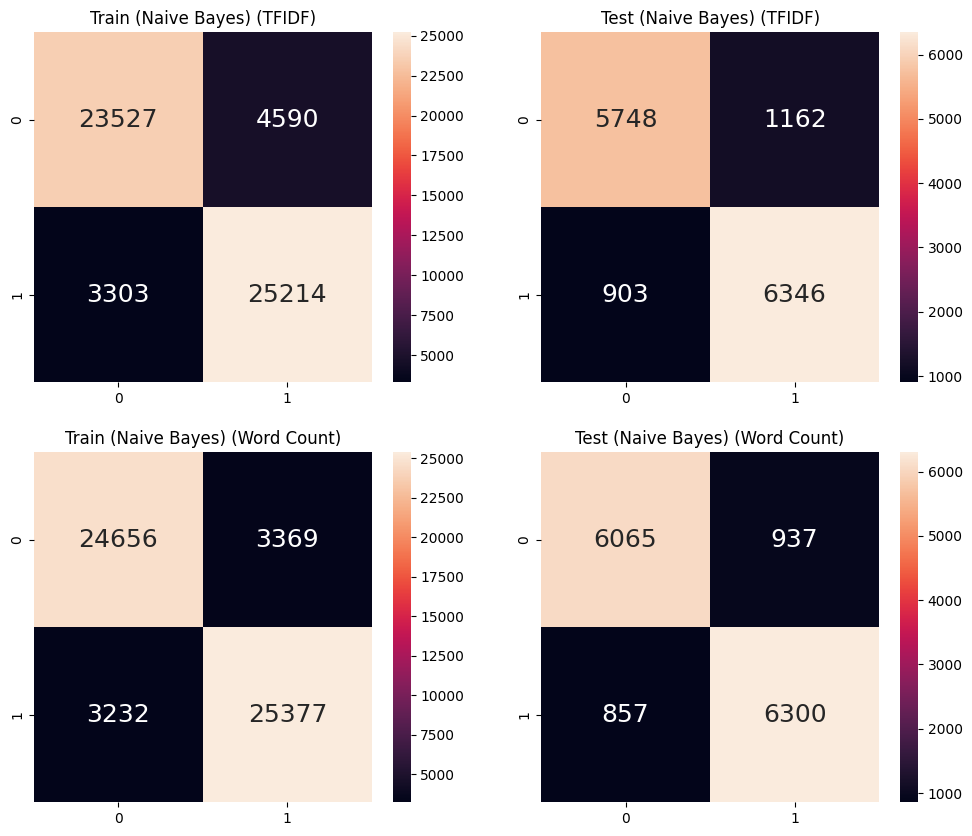

In [ ]:
# For LEM+NER
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, tfidf_tokens = tfidf_process(df_lem_ner)
x_train_wc, x_test_wc, y_train_wc, y_test_wc, wc_tokens = wc_process(df_lem_ner)
cf_and_acc_mnb(x_train_tfidf, y_train_tfidf, x_train_wc, y_train_wc, x_test_tfidf, x_test_wc)